# Manuscript Content

This notebook generates all of the figures and tables for the manuscript exploring the indicators derived from the algorithm developed in this repository and their relationship with the indicators in the NSIDC-0747 dataset, currently referred to as the "Bliss" indicators throughout. And appendix is provided at the end of this document. 

This notebook is structured so as to create a single piece of content (e.g. figure) with each cell, and is designed such that all cells are independent of one another except the very first code cell which needs to be run before any of the following cells. 

In [1]:
import copy
import os
import warnings
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import rasterio as rio
import rioxarray
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D
from pyproj import Transformer
from rasterio.crs import CRS
from rasterio.plot import show
from rasterstats import zonal_stats
from scipy import stats
from shapely.geometry import Polygon

In [ ]:
import os
from pathlib import Path
import mc_setup as mcs
import mc_functions as mcf

# setup environment and handle all file-pathing
# allow importing relative to PROJECT_DIR
# by cd-ing to PROJECT_DIR
project_dir = os.getenv("PROJECT_DIR")
%cd -q "$project_dir"

base_dir = Path(os.getenv("BASE_DIR"))
output_dir = Path(os.getenv("OUTPUT_DIR"))
scratch_dir = Path(os.getenv("SCRATCH_DIR"))

# make the output directory for this notebook if not present
content_dir = output_dir.joinpath("manuscript_content")
content_dir.mkdir(exist_ok=True)

# make ancillary dir
anc_dir = base_dir.joinpath("ancillary")
anc_dir.mkdir(parents=True, exist_ok=True)

# use the FUBU data file created as a product of the pipeline
fubu_fp = output_dir.joinpath("arctic_seaice_fubu_dates_1979-2019.nc")
orac_fp = base_dir.joinpath(
    "nsidc_0747/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)
masie_fp = anc_dir.joinpath("MASIE_regions_polygon_vertices.xls")
poi_coords_fp = base_dir.joinpath("ancillary/points_of_interest.csv")
gshhs_fp = anc_dir.joinpath("gshhg-shp-2.3.7/GSHHS_shp/i/GSHHS_i_L1.shp")
seamask_fp = scratch_dir.joinpath("seamask_3411.tif")

# make input filepaths global in setup module
mcs.fubu_fp = fubu_fp
mcs.orac_fp = orac_fp
mcs.masie_fp = masie_fp
mcs.poi_coords_fp = poi_coords_fp
mcs.gshhs_fp = gshhs_fp
mcs.seamask_fp = seamask_fp

## Download ancillary data

Download the ancillary data files needed for running analyses and creating the manuscript content:  
1. NSIDC-0747 indicators data
2. the MASIE region vertices from NSIDC
3. GSHHG world shoreline polygons from NCEI

### NSIDC-0747 dataset

In [17]:
# User parameters
# set clobber to True to download even if NSIDC-0747 
#   dataset exists locally.
clobber = False

from pipeline.download_nsidc import cmr_download

def download_nsidc0747():
    print("Downloading NSIDC-0747 dataset")
    out_0747_fp = cmr_download([nsidc0747_url], out_0747_dir)
    print(f"NSIDC-0747 written to {out_0747_fp}")
    
    return


# create output directory
out_0747_dir = base_dir.joinpath("nsidc_0747")
out_0747_dir.mkdir(exist_ok=True)

# next, download NSIDC-0747
nsidc0747_url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0747_seaice_melt_indicators_v1/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
if not clobber:
    if not out_0747_dir.joinpath(Path(nsidc0747_url).name).exists():
        download_nsidc0747()
    else:
        print("NSIDC-0747 data already present in $BASE_DIR")
else:
    download_nsidc0747()

NSIDC-0747 already present in $BASE_DIR


### MASIE region vertices

For use in various analyses.

In [16]:
# User parameters
# set clobber to True to download even if MASIE 
#   dataset exists locally.
clobber = False

from manuscript_content.download_ancillary import run_download

def download_masie():
    print("Downloading MASIE vertices...")
    run_download(masie_url, masie_fp)
    print(f"MASIE region vertices written to {masie_fp}")
    
    return


# download MASIE region vertices
masie_url = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02186/ancillary/MASIE_regions_polygon_vertices.xls"

if not clobber:
    if not masie_fp.exists():
        download_masie()
    else:
        print("MASIE region vertices already present in $BASE_DIR")
else:
    download_masie()

MASIE region vertices already present in $BASE_DIR


### GSHHG world shoreline

For use in map-based figures.

In [15]:
# User parameters
# set clobber to True to download even if GSHHG 
#   dataset exists locally.
clobber = False

import zipfile
from manuscript_content.download_ancillary import run_download

def download_extract_gshhg():
    print("Downloading GSHHG world shoreline dataset")
    run_download(gshhg_url, gshhg_zip_fp)
    print(f"GSHHG world shoreline dataset written to {gshhg_zip_fp}")

    # unzip the downloaded shoreline dataset
    print("Extracting the downloaded GSHHG data...")
    with zipfile.ZipFile(gshhg_zip_fp, "r") as zip_ref:
        zip_ref.extractall(anc_dir)
    print(f"GSHHG world shoreline download extracted to {gshhg_dir}")
    
    return


# create extraction directory
gshhg_dir = anc_dir.joinpath("gshhg-shp-2.3.7")
gshhg_dir.mkdir(exist_ok=True)

# download world shoreline polygons
gshhg_url = "https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/gshhg-shp-2.3.7.zip"
gshhg_zip_fp = scratch_dir.joinpath(gshhg_url.split("/")[-1])

if not clobber:
    if not gshhs_fp.exists():
        download_extract_gshhg()
    else:
        print("GSHHG world shoreline dataset already present in $BASE_DIR")
else:
    download_extract_gshhg()

GSHHG world shoreline dataset already present in $BASE_DIR


## Setup

Run the cell below before executing any of the cells that create either of the totals maps, the ice season length maps, or the mean date lag maps. 

In [3]:
def maps_setup():
    """Setup the environment for maps creation. 
    Data needed: FUBU dates, Bliss indicator dates, and landmask in EPSG:3411.
    
    Returns:
        Checks to see whether all required variables are defined, 
        and does so if not.
    """
    global fubu
    global orac
    global landmask
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)
    
    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: landmask
    except NameError:
        landmask = mcf.get_landmask(orac_fp)
        
    return

## Definition totals maps

Create maps of the study area where grid cells are colored by counts of the number of years an indicator was defined. Creates one set of totals maps for each indicator dataset.

#### J&E totals maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_totals_maps.png


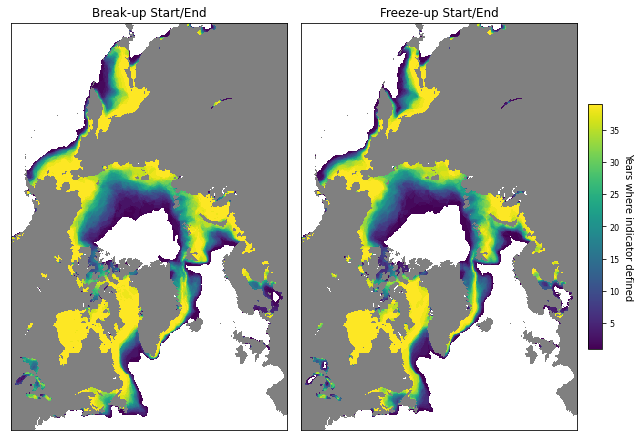

In [4]:
maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_totals_maps(
    fubu,
    ["breakup_start", "freezeup_start"],
    landmask,
    ["Break-up Start/End", "Freeze-up Start/End"],
    content_dir.joinpath(f"Johnson_Eicken_totals_maps.{output_format}"),
)

#### Bliss et al. totals maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Bliss_totals_maps.png


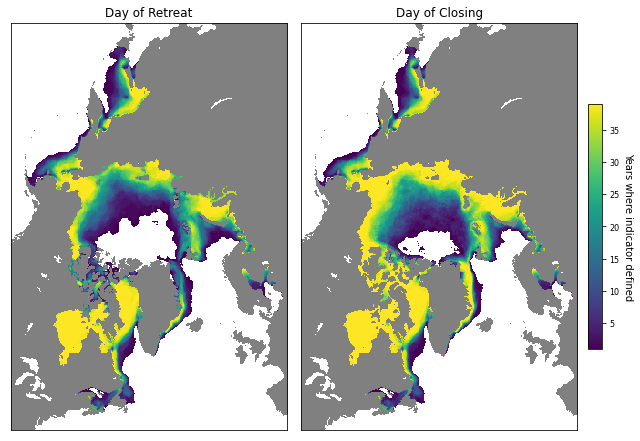

In [4]:
maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_totals_maps(
    orac,
    ["DOR", "DOC"],
    landmask,
    ["Day of Retreat", "Day of Closing"],
    content_dir.joinpath(f"Bliss_totals_maps.{output_format}"),
)


## Ice season length maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/ice_season_length_maps.png


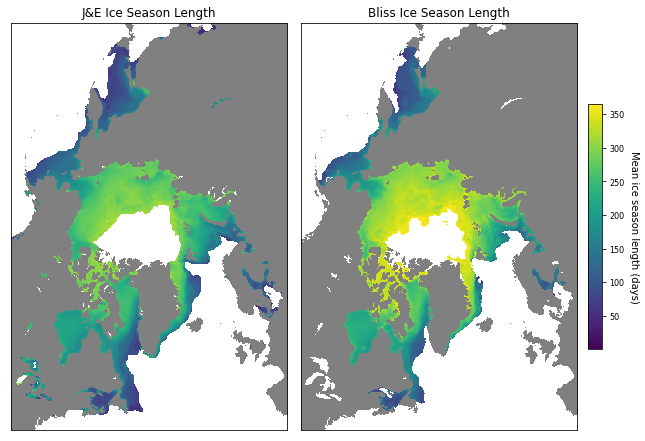

In [4]:
maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_isl_maps(
    fubu,
    orac,
    landmask,
    content_dir.joinpath(f"ice_season_length_maps.{output_format}")
)

## Mean date lag maps

Create maps depicting the mean difference in indicator dates for corresponding indicators between J&E and Bliss et al datasets. Differences computed as $mean( JE - Bliss)$

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/mean_date_lag_maps.png


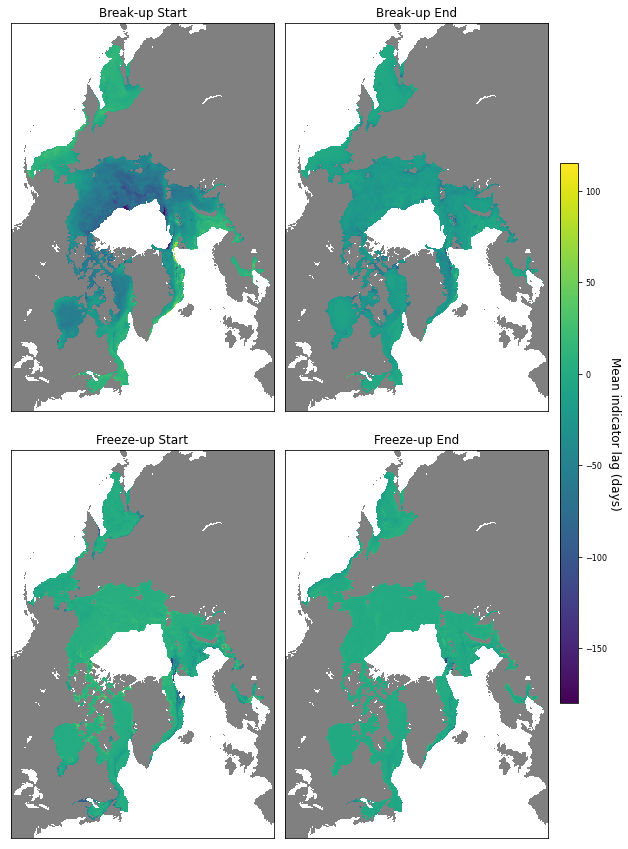

In [4]:
maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_date_lag_maps(
    fubu,
    orac,
    landmask,
    content_dir.joinpath(f"mean_date_lag_maps.{output_format}")
)

## MASIE region zonal stats results

Summarize the indicators for each dataset by mean date and definition rate. Mean day of year is the mean of the indicator ordinal date for years where the indicator was defined. Definition rate is the percentage of years for which the indicator was defined. All values are on pixel-wise basis. 

In [9]:
try: fubu
except NameError: 
    fubu = mcf.load_fubu(fubu_fp)

try: orac
except NameError: 
    orac = mcf.load_orac(orac_fp, fubu)
    
try: masie_polys
except NameError:
    masie_polys = mcf.get_masie_polys(masie_fp)

try: affine
except NameError:
    affine = mcf.get_fubu_affine(fubu_fp)

zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

zs_df

,region,mean_date,def_rate,year,indicator,group,indicator_type,indicator_event,fubu_indicator
0,Beaufort Sea,289.241573,12.1,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
1,Chukchi Sea,300.845802,19.3,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
2,E. Siberian Sea,266.102564,1.6,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
3,Laptev Sea,265.295455,4.2,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
4,Kara Sea,288.731876,16.9,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
...,...,...,...,...,...,...,...,...,...
3739,Baffin Bay,328.444676,8.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3740,Canadian Arch.,275.981520,15.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3741,Hudson Bay,337.186902,36.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3742,Central Arctic,289.920455,9.3,2017,Day of Closing,Bliss,freezeup,end,freezeup_end


## Violin plot setup

Run the cell below before running any of the cells which generate violin plot or histogram figures.

In [ ]:
def violinplot_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

In [ ]:
import geopandas as gpd
import pandas as pd
import pandas as pd
from shapely.geometry import Polygon

masie_df = pd.read_excel(masie_fp, skiprows=1)

In [ ]:
masie_polys = masie_df[["Region Number Identifier", "Name"]].copy()
for index, row in masie_df.iterrows():
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
        print(df_di)
        if pd.isnull(value):
            print(df_di["lat"])
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)

{'lat': [], 'lon': []}
{'lat': [], 'lon': []}
{'lat': [], 'lon': []}
{'lat': [65.3734851649356], 'lon': []}
{'lat': [65.3734851649356], 'lon': [-156.645452750466]}
{'lat': [65.3734851649356, 79.9999999999988], 'lon': [-156.645452750466]}
{'lat': [65.3734851649356, 79.9999999999988], 'lon': [-156.645452750466, -156.479166999999]}
{'lat': [65.3734851649356, 79.9999999999988, 77.6899999999999], 'lon': [-156.645452750466, -156.479166999999]}
{'lat': [65.3734851649356, 79.9999999999988, 77.6899999999999], 'lon': [-156.645452750466, -156.479166999999, -112.339999999999]}
{'lat': [65.3734851649356, 79.9999999999988, 77.6899999999999, 75.6699999999999], 'lon': [-156.645452750466, -156.479166999999, -112.339999999999]}
{'lat': [65.3734851649356, 79.9999999999988, 77.6899999999999, 75.6699999999999], 'lon': [-156.645452750466, -156.479166999999, -112.339999999999, -124.575]}
{'lat': [65.3734851649356, 79.9999999999988, 77.6899999999999, 75.6699999999999, 64.9999999999993], 'lon': [-156.645452750

In [ ]:
from shapely.geometry import Polygon

In [ ]:
poly = Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])

In [ ]:


df_di = {"lat": [], "lon": []}
for idx, value in zip(row.index, row):

    if pd.isnull(value):
        df_di["lat"].append(df_di["lat"][0])
        df_di["lon"].append(df_di["lon"][0])
        break
    if "Lat" in idx:
        df_di["lat"].append(value)
    if "Lon" in idx:
        df_di["lon"].append(value)

return Polygon(list(zip(df_di["lon"], df_di["lat"])))

## Violin plots

Create violin plots that are grouped by indicator and colored by dataset using the MASIE-based zonal summaries. 

### Mean day of year violin plots

In [ ]:
violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_violin_plots(
    zs_df,
    "mean_date",
    "Set3",
    "Mean day of year",
    content_dir.joinpath(f"mean_doy_violin_plots.{output_format}"),
)

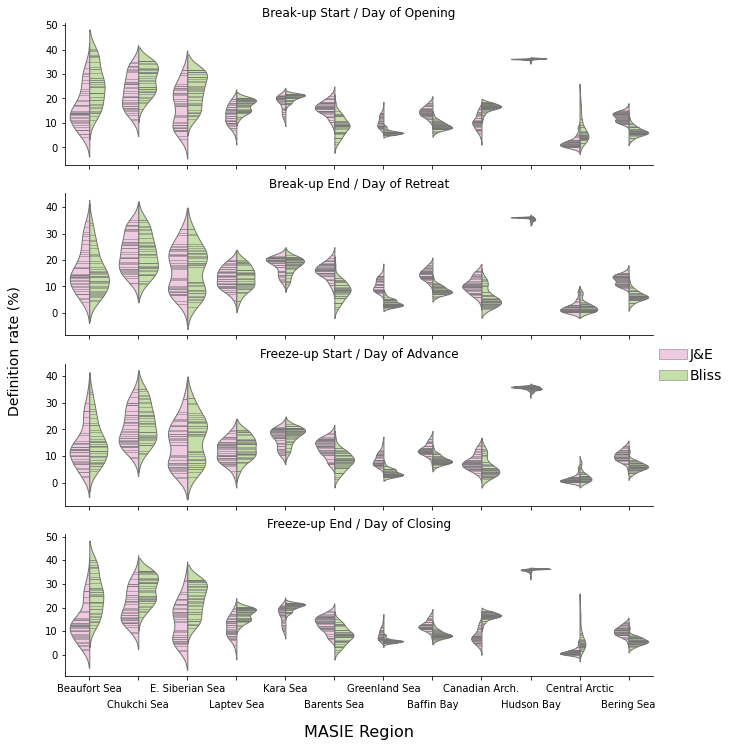

In [ ]:
violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_violin_plots(
    zs_df,
    "def_rate",
    "PiYG",
    "Definition rate (%)",
    content_dir.joinpath(f"definition_rate_violin_plots.{output_format}"),
)

## MASIE mean date histograms

Generate histograms of mean indicator dates for a subset of MASIE regions.

In [ ]:
violinplot_setup()

output_format = "png"
# output_format = "eps"

# mcf.make_masie_mean_histograms(
#     fubu,
#     orac,
#     masie_polys,
#     affine,
#     content_dir.joinpath(f"masie_mean_histograms.{output_format}")
# )

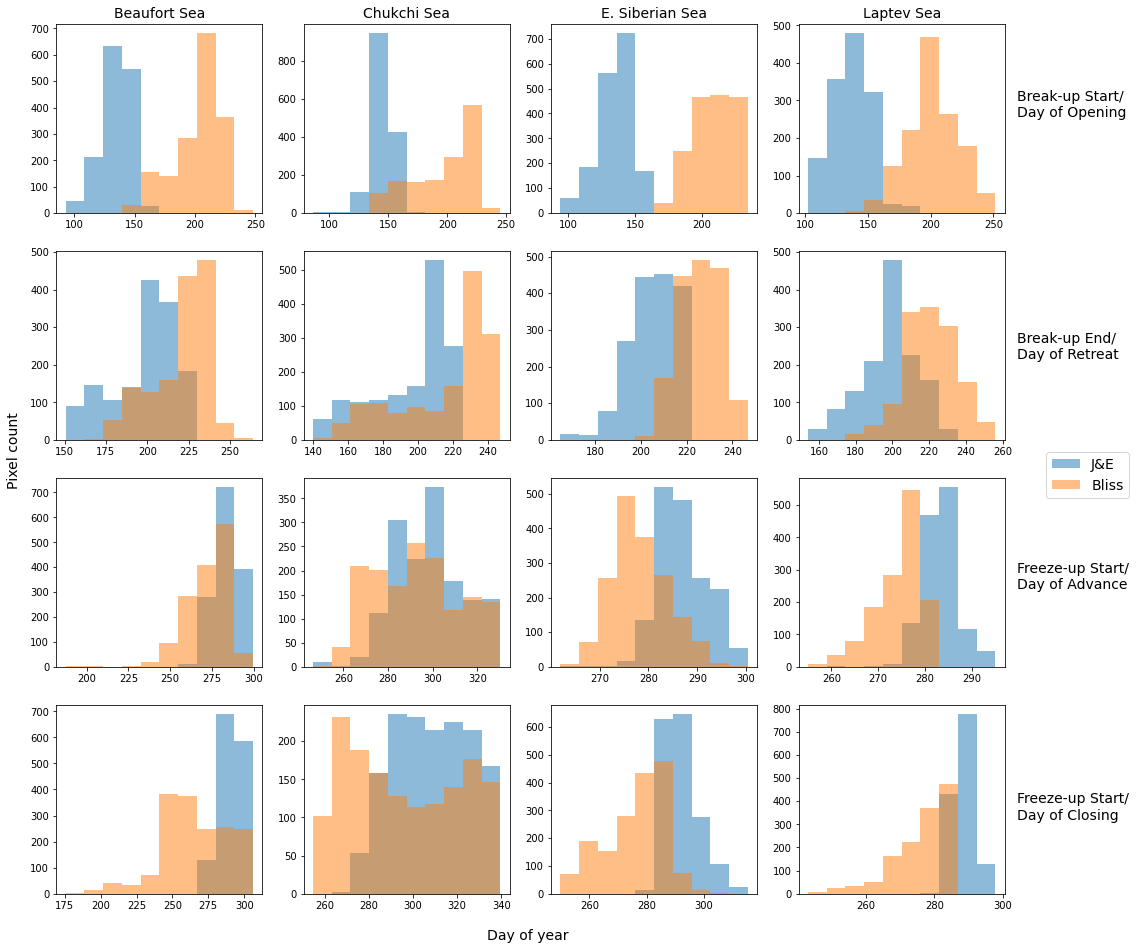

In [4]:
violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_masie_mean_histograms(
    fubu, 
    orac, 
    masie_polys, 
    affine, 
    content_dir.joinpath(f"masie_mean_histograms.{output_format}")
)

## Point-of-interest maps 

In [ ]:
def poi_maps_setup():
    global fubu
    global orac
    global poi_coords
    global world_shore
    global seamask_src
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: poi_coords
    except NameError:
        poi_coords = mcf.load_poi_coords(poi_coords_fp)

    try: world_shore
    except NameError:
        world_shore = mcf.load_world_shore(gshhs_fp)

    try: seamask_src
    except NameError:
        seamask_src = mcf.load_seamask(seamask_fp)

## Maps for pixel selections for points of interest

Maps depicting the pixels chosen for aggregating values to represent points of interest.

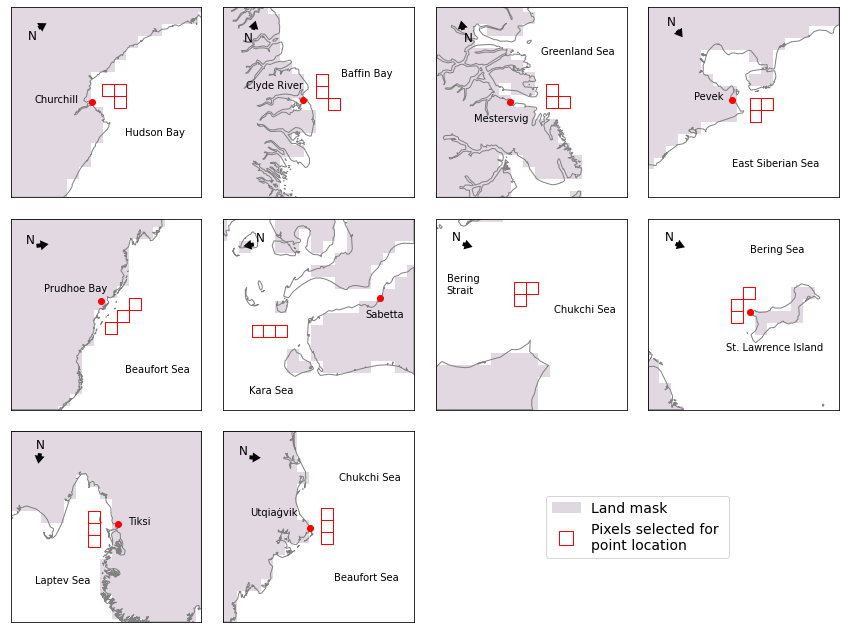

In [2]:
poi_maps_setup()
    
output_format = "png"
# output_format = "eps"

mcf.make_poi_maps(
    poi_coords,
    world_shore,
    seamask_src,
    content_dir.joinpath(f"point_trends_maps.{output_format}")
)

## Points-of-interest trends setup

Run the cell below before running any of the cells which generate point-of-interest trends plots.

In [5]:
def poi_trends_setup():
    global fubu
    global orac
    global poi_coords
    global poi_data
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: poi_coords
    except NameError:
        poi_coords = mcf.load_poi_coords(poi_coords_fp)

    try: poi_data
    except NameError:
        poi_data = mcf.get_poi_data(poi_coords, fubu, orac)

## Trend analysis for points of interest

Regress indicator dates against year for the points of interest. Save plots and model fit results.

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_start.png


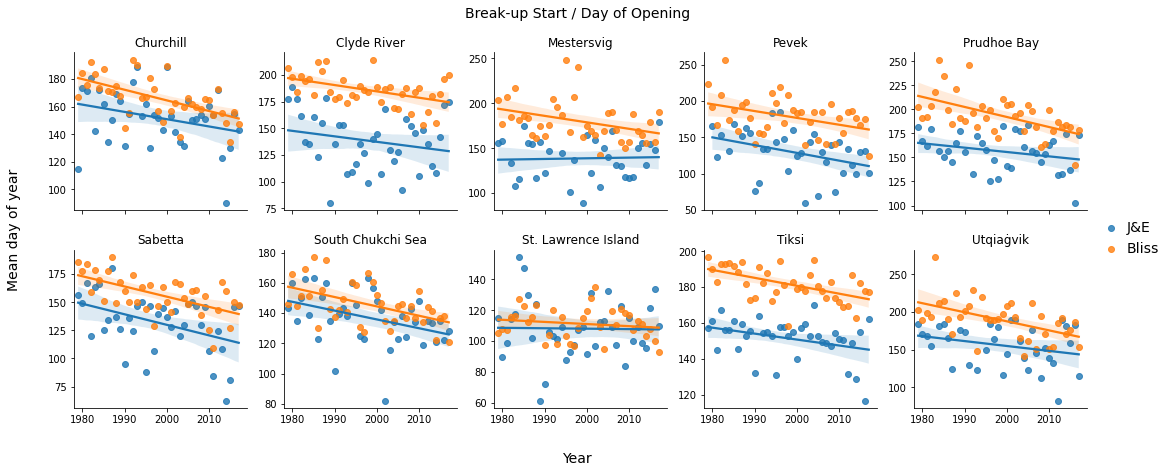

In [6]:
poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Break-up Start / Day of Opening", 
    content_dir, 
    output_format
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_end.png


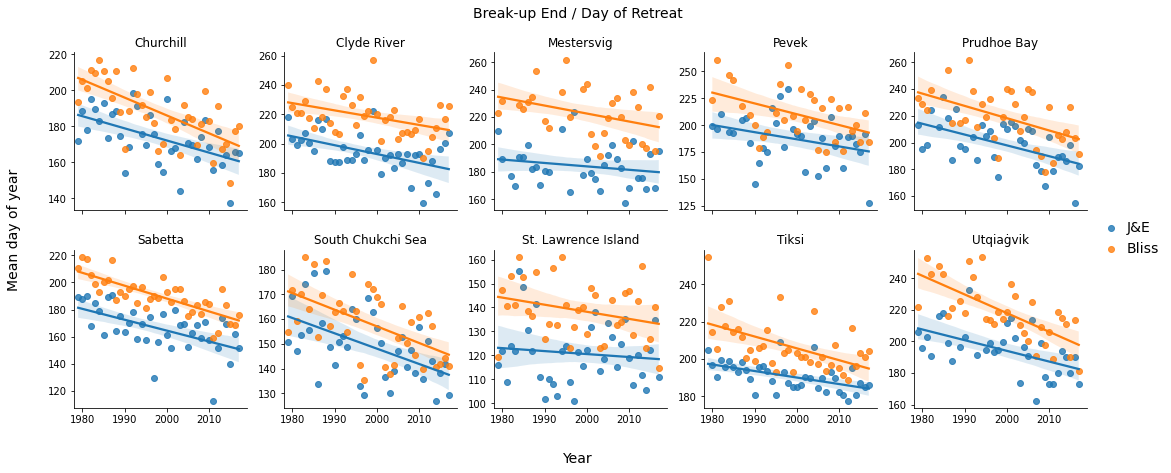

In [7]:
poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Break-up End / Day of Retreat", 
    content_dir, 
    output_format
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_freezeup_start.png


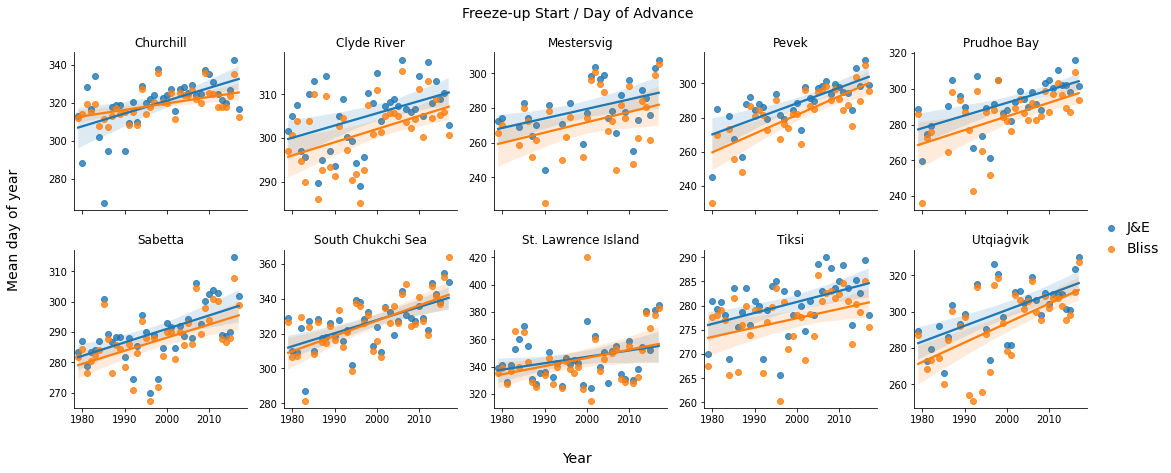

In [8]:
poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Freeze-up Start / Day of Advance", 
    content_dir, 
    output_format
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_freezeup_end.png


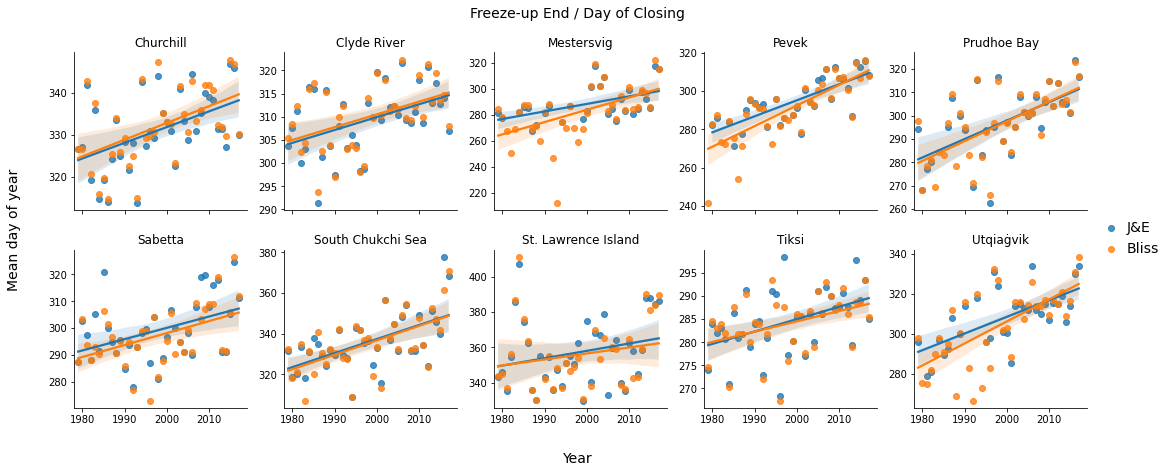

In [9]:
poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Freeze-up End / Day of Closing", 
    content_dir, 
    output_format
)

## Trends results for points of interest

In [10]:
poi_trends_setup()

poi_results_table = mcf.make_poi_results_table(
    poi_data, 
    content_dir.joinpath("point_trends_results_table.csv")
)

poi_results_table

Point trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_results_table.csv


,Location,Indicator Group,Indicator,Slope,r2,p
0,Churchill,Bliss,Day of Advance,0.3,0.52,< 0.01**
1,Churchill,Bliss,Day of Closing,0.4,0.51,< 0.01**
2,Churchill,Bliss,Day of Opening,-0.8,-0.59,< 0.01**
3,Churchill,Bliss,Day of Retreat,-1.0,-0.67,< 0.01**
4,Churchill,J&E,Break-up End,-0.7,-0.54,< 0.01**
...,...,...,...,...,...,...
75,Utqiaġvik,Bliss,Day of Retreat,-1.2,-0.71,< 0.01**
76,Utqiaġvik,J&E,Break-up End,-0.7,-0.52,< 0.01**
77,Utqiaġvik,J&E,Break-up Start,-0.7,-0.27,0.11
78,Utqiaġvik,J&E,Freeze-up End,0.8,0.66,< 0.01**


## Points-of-interest / MASIE trends setup

Run the cell below before running any of the cells that generate MASIE - point-of-interest comparison trends plots.

In [14]:
def poi_masie_trends_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    global poi_coords
    global poi_data
    global poi_masie_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)
        
    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

    try: poi_coords
    except NameError:
        poi_coords = mcf.load_poi_coords(poi_coords_fp)

    try: poi_data
    except NameError:
        poi_data = mcf.get_poi_data(poi_coords, fubu, orac)
    
    try: poi_masie_df
    except NameError:
        poi_masie_df = mcf.concat_masie_poi_data(zs_df, poi_data)
        
    return poi_masie_df

## Trend analysis of MASIE region / point of interest comparison

Plot the trends of the points of interest against the MASIE region averages.

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_start.png


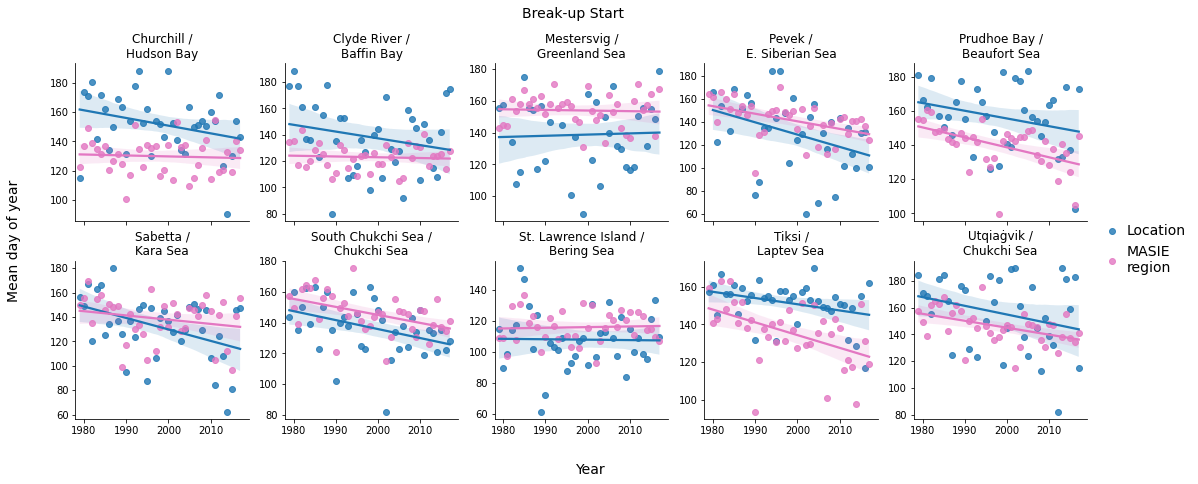

In [16]:
poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    "Break-up Start",
    content_dir,
    output_format,
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_end.png


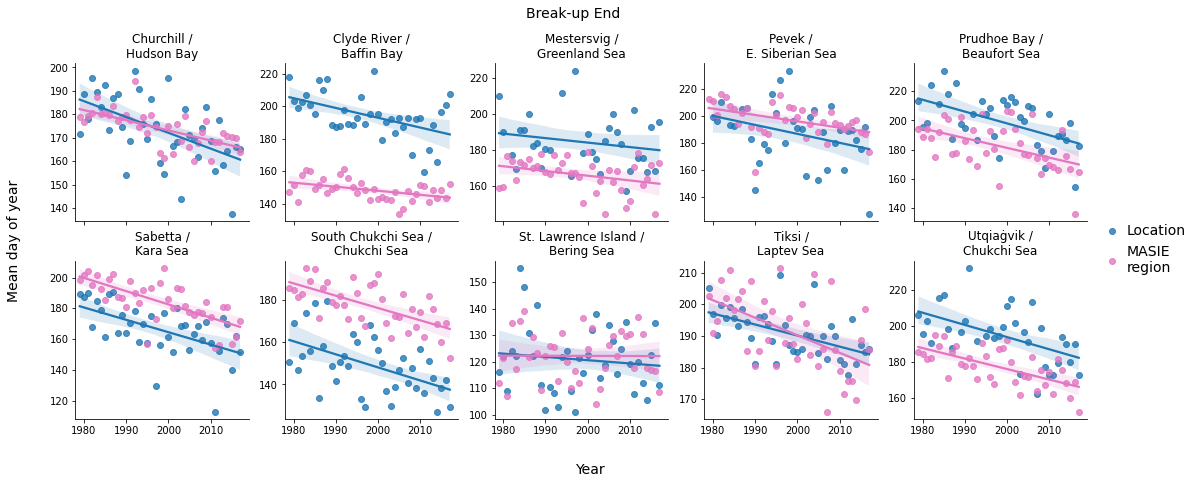

In [17]:
poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Break-up End"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_start.png


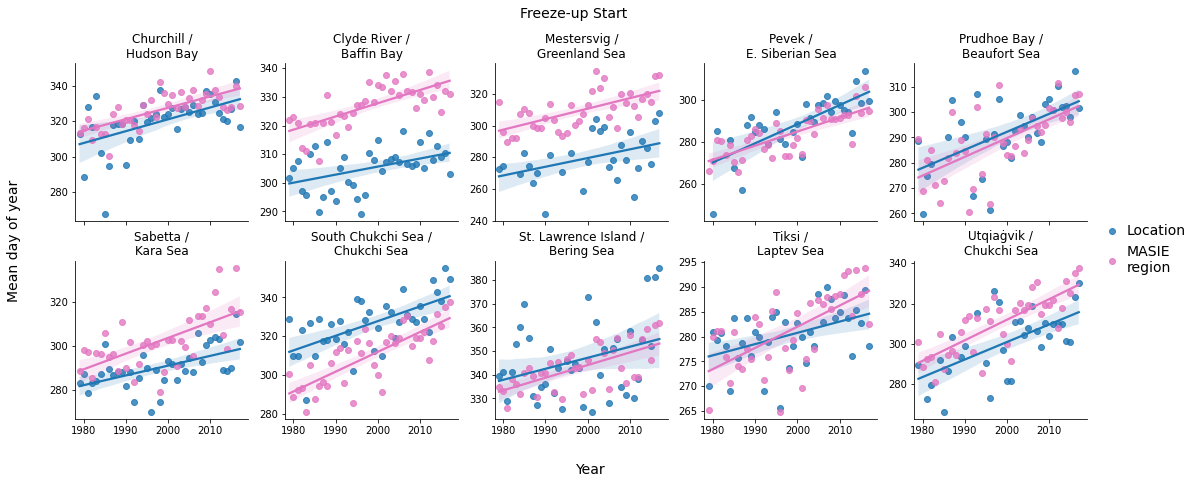

In [18]:
poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Freeze-up Start"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_end.png


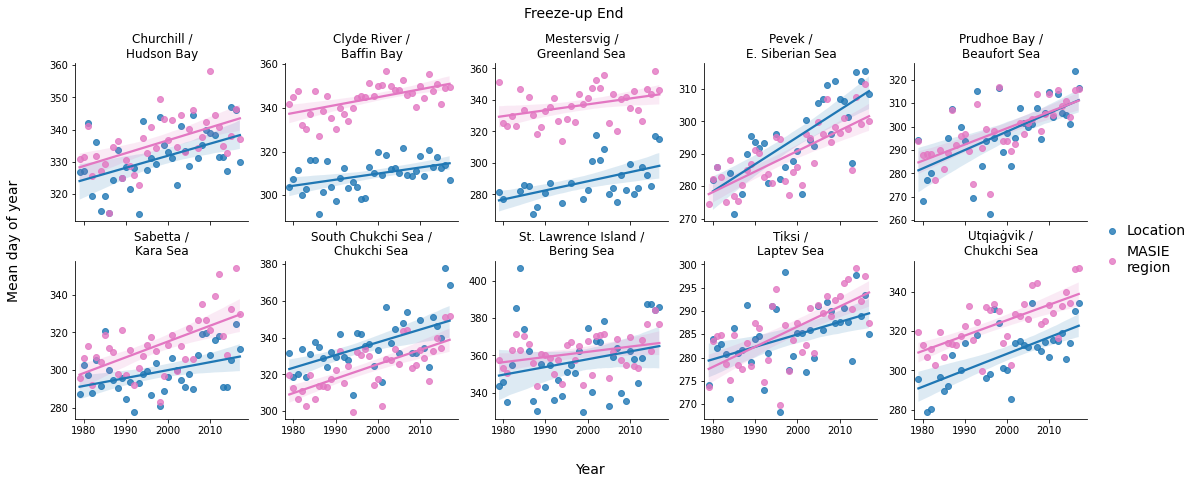

In [19]:
poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Freeze-up End"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

## Setup for MASIE trends plots

Run the cell below before running any of the cells which generate trends plots for MASIE regions.

In [20]:
def masie_trends_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)
        
    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)
        
    return zs_df

## MASIE trends plots

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_start_trends_plots.png


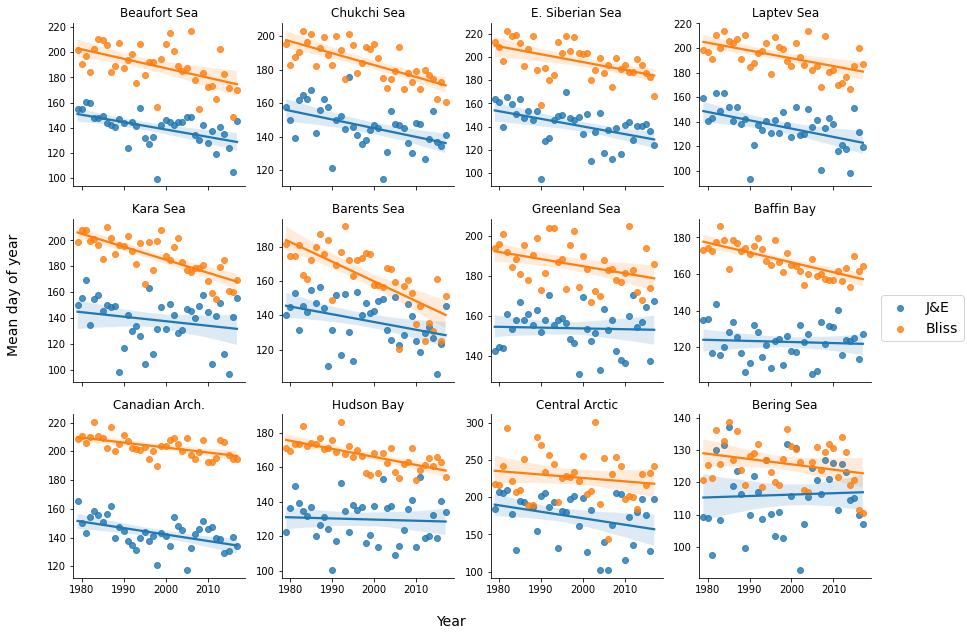

In [21]:
masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "breakup_start", 
    content_dir.joinpath(f"masie_breakup_start_trends_plots.{output_format}")
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_end_trends_plots.png


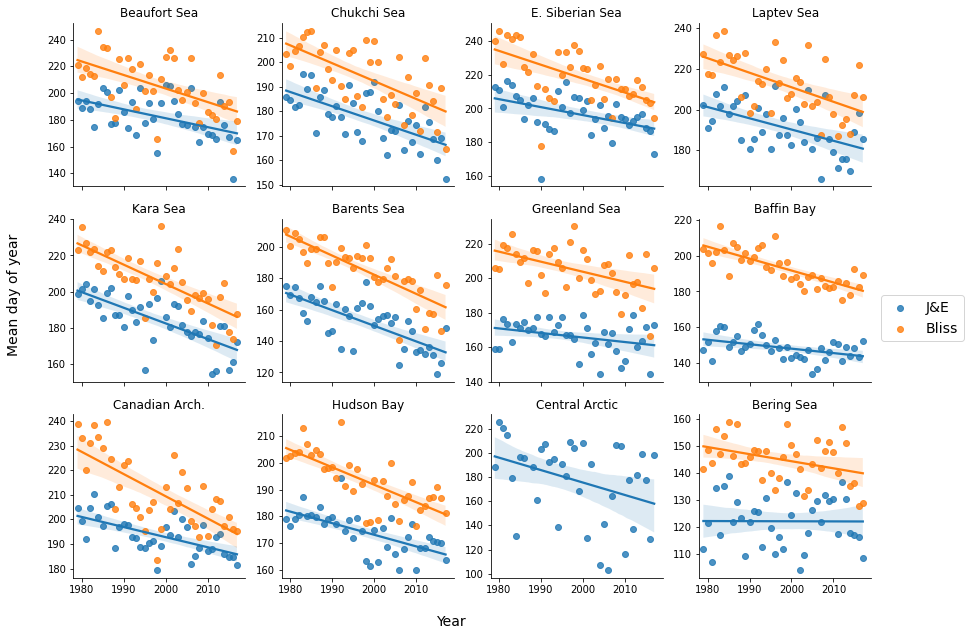

In [22]:
masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "breakup_end", 
    content_dir.joinpath(f"masie_breakup_end_trends_plots.{output_format}")
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_start_trends_plots.png


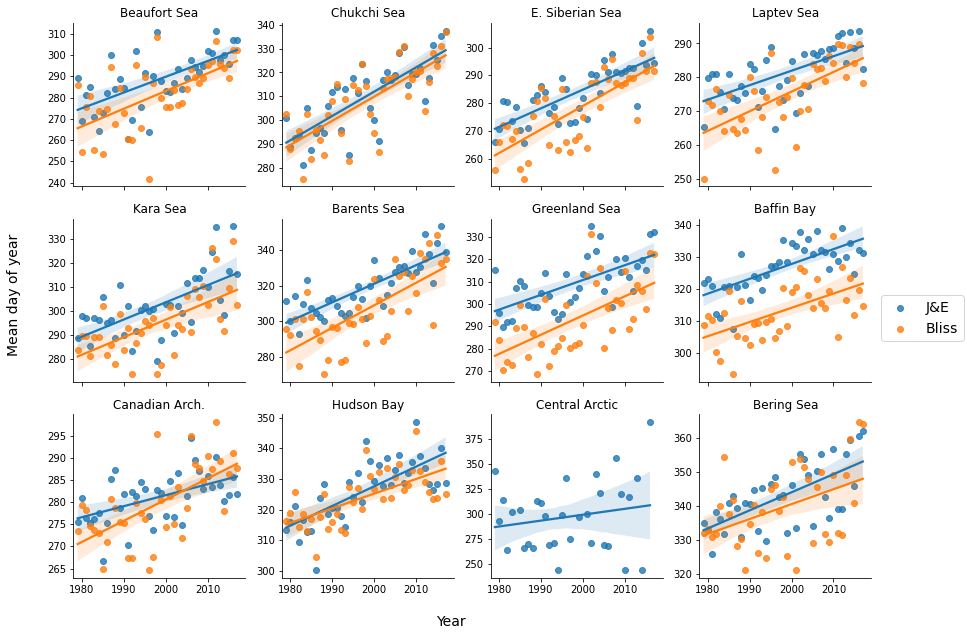

In [23]:
masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "freezeup_start", 
    content_dir.joinpath(f"masie_freezeup_start_trends_plots.{output_format}")
)

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_end_trends_plots.png


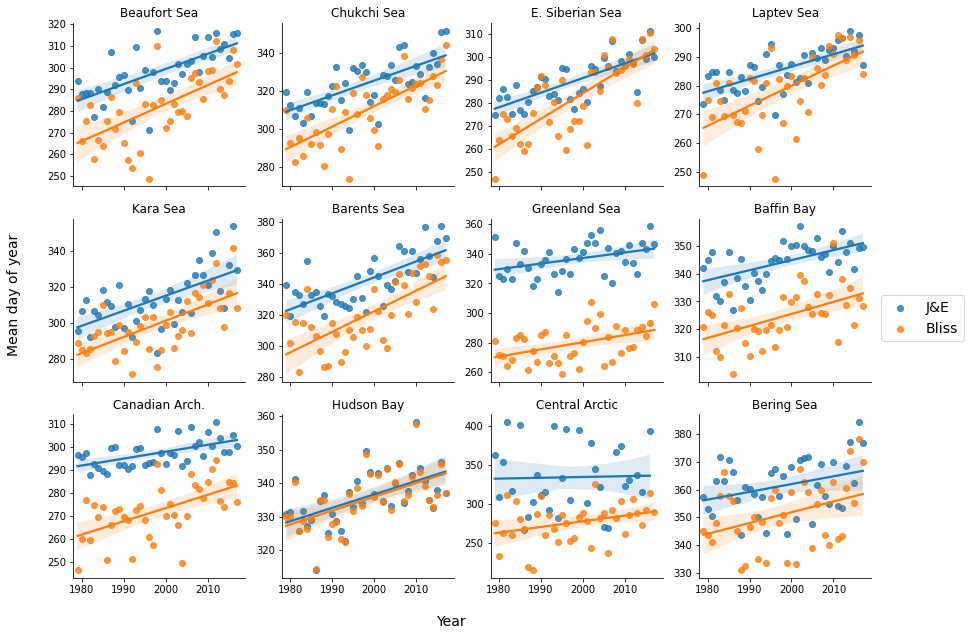

In [24]:
masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "freezeup_end", 
    content_dir.joinpath(f"masie_freezeup_end_trends_plots.{output_format}")
)

In [29]:
import pandas as pd
import numpy as np
from scipy import stats

# discard regions with no indicators
zs_df = zs_df[~np.isnan(zs_df["mean_date"])]
rows = []
for groups, df in zs_df.groupby(["region", "group", "indicator"]):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

masie_lm_results = pd.DataFrame(rows, columns=["Region", "Indicator Group", "Indicator", "Slope", "r2", "p"])
masie_trends_results_fp = content_dir.joinpath("masie_trends_results_table.csv")
masie_lm_results.to_csv(masie_trends_results_fp)
print(f"MASIE trends results written to {masie_trends_results_fp}")
masie_lm_results

MASIE trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_trends_results_table.csv


,Region,Indicator Group,Indicator,Slope,r2,p
0,Baffin Bay,Bliss,Day of Advance,0.4,0.57,< 0.01**
1,Baffin Bay,Bliss,Day of Closing,0.4,0.52,< 0.01**
2,Baffin Bay,Bliss,Day of Opening,-0.5,-0.74,< 0.01**
3,Baffin Bay,Bliss,Day of Retreat,-0.7,-0.77,< 0.01**
4,Baffin Bay,J&E,Break-up End,-0.2,-0.44,< 0.01**
...,...,...,...,...,...,...
89,Laptev Sea,Bliss,Day of Retreat,-0.7,-0.58,< 0.01**
90,Laptev Sea,J&E,Break-up End,-0.6,-0.52,< 0.01**
91,Laptev Sea,J&E,Break-up Start,-0.7,-0.48,< 0.01**
92,Laptev Sea,J&E,Freeze-up End,0.4,0.68,< 0.01**


# Appendix

This notebook provides supplementary material for the manuscript. 

## Steele indicators differences in definition totals

This section presents a summary of the differences between the Steele indicator groups total definition counts (freeze-up group: Day of Advance, Day of Closing; break-up group: Day of Opening, Day of Retreat). For the totals maps figure, we only included the Day of Opening / Day of Closing the differences between definition rates are  small to warrant depiction of totals for all four indicators. This sectin simply justifies that exclusion:

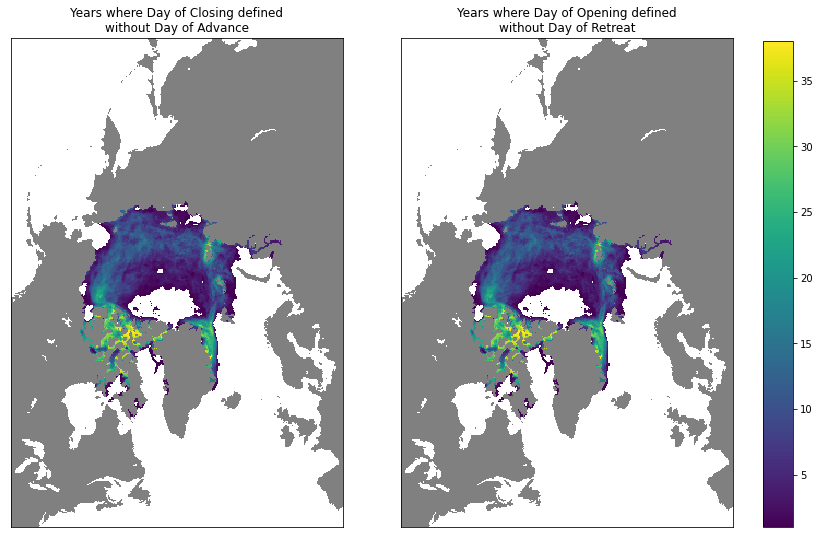

In [48]:
import copy
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


def prep_exclusive_counts(orac_ds, indicator1, indicator2):
    """Count instances where indicator1 is defined but not
    indicator2"""
    # create array for counting and set exclusive 
    # instances to 1 and sum to count
    exclusive_arr = np.zeros_like(orac_ds["DOC"].values)
    exclusive_arr[
        (orac_ds[indicator1].values > 0) & 
        (orac_ds[indicator2].values <= 0)
    ] = 1
    
    # prep for plotting with masking
    plot_arr = np.ma.masked_where(
        orac_ds["DOA"].values[0] == -4, 
        exclusive_arr.sum(axis=0)
    )
    
    return plot_arr


def plot_exclusive_counts(plot_arrs, titles):
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_under(color="white")
    cmap.set_bad(color="gray")
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    for arr,ax,title in zip(plot_arrs, axs, titles):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=38)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0)
    cbar_ax = fig.add_axes([0.9, 0.125, 0.03, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return


os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/"
base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
# fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
#converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
# with rio.open(converted_fp) as src:
#     # defined for global reference
#     fubu_landmask = src.read(1) == 254
#     # meta = src.meta

# fubu_ds = xr.load_dataset(fubu_fp)

orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

# keys in this dict are indicators that may be defined
# even the conjugate indicator is not 
indicator_lu = {"DOC": "DOA", "DOO": "DOR"}
plot_arrs = [prep_exclusive_counts(orac_ds, i, indicator_lu[i]) for i in ["DOC", "DOO"]]
   
# plot data
titles = [
    "Years where Day of Closing defined\nwithout Day of Advance",
    "Years where Day of Opening defined\nwithout Day of Retreat",
]

plot_exclusive_counts(plot_arrs, titles)

But the converse conditions are not true:

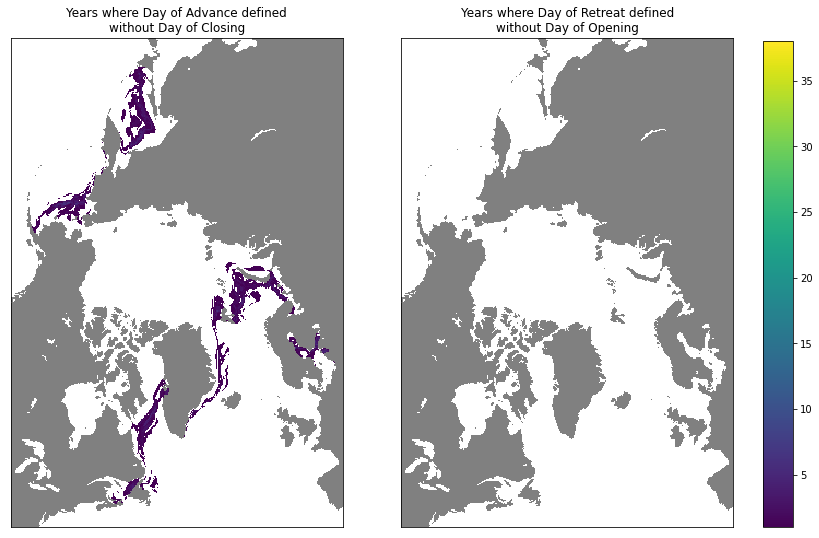

In [49]:
indicator_lu = {"DOA": "DOC", "DOR": "DOO"}
plot_arrs = [prep_exclusive_end_counts(orac_ds, i, indicator_lu[i]) for i in ["DOA", "DOR"]]
    
# plot data
titles = [
    "Years where Day of Advance defined\nwithout Day of Closing",
    "Years where Day of Retreat defined\nwithout Day of Opening",
]

plot_exclusive_counts(plot_arrs, titles)